# Contents

In this notebook:

(1) we first import the resource-function matrix $\bf P$, computed from the RCF tensor of the Na Redona dataset based on Eq.1 of the paper.

(2) we visualize $\bf P$ along with some randomizations and compute NODF for binarizations.

(3) we build nestedness-based rankings (ordering species and functions in terms of their participation strength in $\bf P$), along with suitably defined null models.

(4) we build and plot $\Phi$ and $\Pi$

(5) we look into hierarchical clustering properties of $\bf P$.

(6) we compute the conditioned $\Phi|_i$ and $\Pi|^\alpha$, and the keystonness scores

(7) we build a null model for the keystonness scores

#### IMPORTS AND USEFUL USER-DEFINED FUNCTIONS

In [1]:
## IMPORTS AND USEFUL USER-DEFINED FUNCTIONS

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.cluster import hierarchy
from itertools import permutations
import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components
import scipy as sp

def plot_std_shaded_region(data):
    # Calculate mean and standard deviation
    mean_vals = np.mean(data, axis=0)
    std_vals = np.std(data, axis=0)

    # Create a figure and axis
    fig, ax = plt.subplots()

    # Plot the mean line
    ax.plot(mean_vals, label='Mean')

    # Plot the shaded region representing standard deviation
    ax.fill_between(range(len(mean_vals)), mean_vals - std_vals, mean_vals + std_vals, alpha=0.2, label='Standard Deviation')

    # Set labels and title
    ax.set_xlabel('Data Points')
    ax.set_ylabel('Values')
    ax.set_title('Mean and Standard Deviation Plot')

    # Show legend
    ax.legend()

    # Show the plot
    plt.show()

def plot_dendrogram_with_names(dissimilarity_matrix, leaf_names):
    # Perform hierarchical clustering
    linkage_matrix = hierarchy.linkage(dissimilarity_matrix, method='complete')

    # Plot the dendrogram with leaf names
    # Override the default linewidth.
    plt.rcParams['lines.linewidth'] = 2.5
    plt.figure(figsize=(10, 6))
    hierarchy.dendrogram(linkage_matrix, labels=leaf_names, leaf_rotation=90,leaf_font_size=15)
    #plt.xlabel('')
    plt.ylabel('Scale', fontsize=18)
    #plt.title('Hierarchical Clustering Dendrogram')
    plt.show()



def plot_heatmap(array, x_labels, y_labels,heatmap_name):
    plt.figure(figsize=(15, 4))
    plt.imshow(array, cmap='viridis', interpolation='nearest')
    plt.colorbar()
    plt.xticks(np.arange(len(x_labels)), x_labels, rotation=90, fontsize=15)
    plt.yticks(np.arange(len(y_labels)), y_labels, fontsize=15)
    #plt.xlabel('X Label')
    #plt.ylabel('Y Label')
    plt.title(heatmap_name)
    plt.show()
    
def largest_connected_component(adj_matrix):
    # Convert adjacency matrix to a sparse matrix
    adj_sparse = csr_matrix(adj_matrix)
    # Compute connected components
    num_components, labels = connected_components(adj_sparse)
    # Find the largest connected component
    largest_component_label = np.argmax(np.bincount(labels))
    # Get the indices of the nodes in the largest component
    largest_component_indices = np.where(labels == largest_component_label)[0]
    return largest_component_indices
    


def percolacion_funciones(matriz_p,cual):
    #cual 0 --> funciones
    #cual 1 --> plantas
    #lista de funciones
    lista_funciones = ['decomposition','fungal pathogenicity','nutrient uptake','herbivory','pollination','seed dispersal']
    lista_plantas = ['Withania frutescens', 'Lavatera maritima', 'Olea europaea var. sylvestris', 'Euphorbia dendroides', 'Medicago arborea', 'Suaeda vera', 'Limonium sp', 'Diplotaxis ibicensis', 'Arisarum vulgare', 'Geranium molle', 'Narcissus tazetta', 'Ephedra fragilis', 'Fagonia cretica', 'Asparagus horridus', 'Chenopodium murale', 'Heliotropium sp']
    function_dict = {"decomposition":0, "fungal pathogenicity":1,"nutrient uptake":2, "herbivory":3,"pollination": 4,"seed dispersal":5}
    plant_dict ={'Withania frutescens':0, 'Lavatera maritima':1, 'Olea europaea var. sylvestris':2, 'Euphorbia dendroides':3, 'Medicago arborea':4, 'Suaeda vera':5, 'Limonium sp':6, 'Diplotaxis ibicensis':7, 'Arisarum vulgare':8, 'Geranium molle':9, 'Narcissus tazetta':10, 'Ephedra fragilis':11, 'Fagonia cretica':12, 'Asparagus horridus':13, 'Chenopodium murale':14, 'Heliotropium sp':15}
    #hago permutacion en la lista
    vector_AUC_w=[]
    vector_AUC=[]
    if(cual==0):
        lista=lista_funciones
        AUC_max=81
        AUC_w_max=0
        AUC_min=66
        AUC_w_min=10000
        for perm in permutations(lista):
            matriz_p_actualizada = matriz_p.copy()
            AUC=0
            AUC_w=0
            LCC=[16]
            for funcion in perm:
                row_to_remove=function_dict[funcion]
                #calculo el peso quitado
                peso_quitado=0
                vector=matriz_p_actualizada[:,row_to_remove].copy()
                for i in range(len(vector)):
                    for j in range(len(vector)):
                        peso_quitado=peso_quitado + vector[i]*vector[j]                       
                #peso_quitado=sum(np.matmul(matriz_p_actualizada[:,row_to_remove],np.transpose(matriz_p_actualizada[:,row_to_remove]))
                #quitar de la matriz las entradas adecuadas
                matriz_p_actualizada[:,row_to_remove]=0
                LCCnew=len(largest_connected_component(np.matmul(matriz_p_actualizada, np.transpose(matriz_p_actualizada))))
                print(LCCnew)
                LCC.append(LCCnew)
                #calcular la LCC y sumarla a la AUC
                AUC_w=AUC_w+(peso_quitado)*LCC[-1] + peso_quitado*(LCC[-2]-LCC[-1])*0.5 #trapecio, para AUC weighted
                AUC=AUC+ LCC[-1] #AUC sin pesar
            print('orden:',perm)
            print('AUC=',AUC,'AUC_w',AUC_w)
            print()
            vector_AUC_w.append(AUC_w)
            vector_AUC.append(AUC)
            if(AUC==AUC_max):
                if(AUC_w>AUC_w_max):
                    max_AUC_list=perm
                    AUC_w_max=AUC_w
                    max_LCC_list=LCC
            if(AUC==AUC_min):
                if(AUC_w<AUC_w_min):
                    min_AUC_list=perm
                    AUC_w_min=AUC_w
                    min_LCC_list=LCC
    elif(cual==1):
        print('INCOMPLEEEEETE')
        
            
    return AUC_w_max,max_AUC_list,AUC_w_min,min_AUC_list,vector_AUC_w,max_LCC_list,min_LCC_list



# Importing and plotting the resource-function matrix P

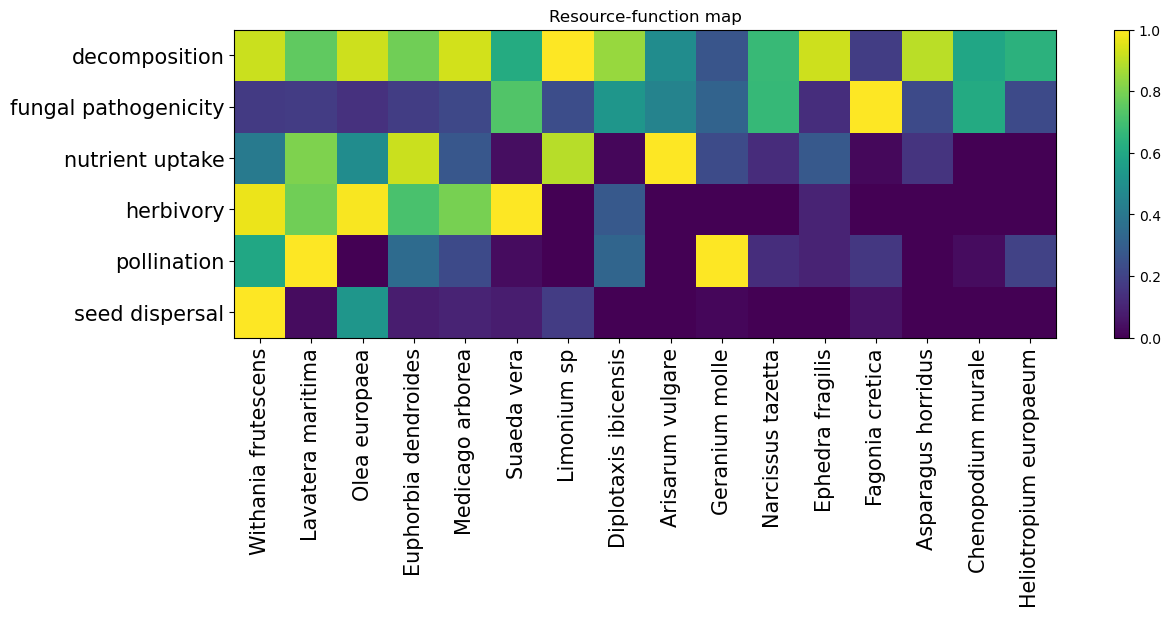

In [2]:
#extract resource function matrix

df = pd.read_csv('data/input/P_matrix.csv')
row_names = df.columns.values.tolist()
function_names=row_names[1:]
column_names = df.iloc[:, 0].values.tolist()
plant_names=column_names
check=df.to_numpy()
weights=check[:,1:].astype(float)

#print('function list:')
#print(function_names)

#print('plant list:')
#print(plant_names)

#print('entries of the resource-function map:')
#print(weights)

plot_heatmap(np.transpose(weights), plant_names, function_names,'Resource-function map')
plt.show()


# NESTEDNESS AND NULL MODEL EE 
#### This is the binary version based on NODF, for the quantitative version based on WNODF and the FF null model, see the Fortran code 

In [3]:
# NODF FUNCTIONS

# -*- coding: utf-8 -*-
"""
Created on Wed Oct 18 2017

Module:
    nestedness_calculator.py

Author:
    Mika Straka

Description:
    Calculator of the nestedness of binary biadjacency matrices.

    Implemented algorithms are:
        - NODF (Nestedness based on Overlap and Decreasing Fill) [AlmeidaNeto]_

Usage:
    Be ``mat`` a two-dimensional binary NumPy array. The nodes of the two
    bipartite layers are ordered along the rows and columns, respectively.

    The NODF nestedness can be calculated directly without initializing a
    class instance::

        >>> from nestedness_calculator import NestednessCalculator
        >>> nodf_score = NestednessCalculator(mat).nodf(mat)

    When calling ``NestednessCalculator(mat)``, the matrix is tested for
    binarity. Furthermore, if one or more columns or rows consist only of zeros,
    the program aborts.

References:
.. [AlmeidaNeto] `M. Almeida-Neto, P. Guimareas, P. R. Guimaraes, R. D Loyala,
    W. Ulrich, A consistent metric for nestedness analysis in ecological
    systems: reconciling concept and measurement, Oikos 117: 1227-1239 (2008),
    <http://dx.doi.org/10.1111/j.0030-1299.2008.16644.x>`_
"""

import numpy as np


class NestednessCalculator(object):
    """Calculates the nestedness of the input matrix.

    The algorithms that have been implemented are:
        - NODF (Nestedness based on Overlap and Decreasing Fill)
    """
    def __init__(self, mat):
        """Initialize the Nestedness calculator and check the input matrix.

        :param mat: binary input matrix
        :type mat: numpy.array
        """
        self.check_input_matrix_is_binary(mat)
        self.check_degrees(mat)

    @staticmethod
    def check_input_matrix_is_binary(mat):
        """Check that the input matrix is binary, i.e. entries are 0 or 1.

        :param mat: binary input matrix
        :type mat: numpy.array

        :raise AssertionError: raise an error if the input matrix is not
            binary
        """
        assert np.all(np.logical_or(mat == 0, mat == 1)), \
            "Input matrix is not binary."

    @staticmethod
    def check_degrees(mat):
        """Check that rows and columns are not completely zero.

        :param mat: binary input matrix
        :type mat: numpy.array

        :raise AssertionError: raise an error if the input matrix has
            completely zero rows or columns.
        """
        assert np.all(mat.sum(axis=1) != 0), \
            "Input matrix rows with only zeros, abort."
        assert np.all(mat.sum(axis=0) != 0), \
            "Input matrix columns with only zeros, abort."

################################################################################
# NODF - Nestedness based on Overlap and Decreasing Fill
################################################################################

    def get_paired_nestedness(self, mat, rows=True):
        """Calculate the paired nestedness along the rows or columns of the.

        :param mat: binary input matrix
        :type mat: numpy.array
        :param rows: if True, pairs are calculated along the rows, if False
            along the columns
        :type rows: bool

        :returns: degree of paired nestedness
        :rtype: float

        The method uses the algorithm described in the `BiMat framework for
        MATLAB <https://bimat.github.io/alg/nestedness.html>`_.
        """
        if rows:
            # consider rows
            po_mat = np.dot(mat, mat.T)
            degrees = mat.sum(axis=1)
        else:
            # consider cols
            po_mat = np.dot(mat.T, mat)
            degrees = mat.sum(axis=0)
        assert len(degrees) == len(po_mat)

        neg_delta = (degrees != degrees[:, np.newaxis])
        deg_matrix = degrees * np.ones_like(po_mat)
        deg_minima = np.minimum(deg_matrix, deg_matrix.T)
        n_pairs = po_mat[neg_delta] / (2. * deg_minima[neg_delta])
        return n_pairs.sum()

    def nodf(self, mat):
        """Calculate the NODF nestedness of the input matrix [AlmeidaNeto]_.

        :param mat: binary input matrix
        :type mat: numpy.array

        :returns: NODF nestedness of the input matrix
        :rtype: float


        The algorithm has been tested by comparison with the `online tool
        provided at <http://ecosoft.alwaysdata.net/>`_
        """
        n_pairs_rows = self.get_paired_nestedness(mat, rows=True)
        n_pairs_cols = self.get_paired_nestedness(mat, rows=False)
        norm = np.sum(np.array(mat.shape) * (np.array(mat.shape) - 1) / 2.)
        nodf = (n_pairs_rows + n_pairs_cols) / norm
        return nodf


### Calculation of nestedness value on a thresholded (binarized) version of P, and computation of a null model where we shuffle entries in binarized-P such that we require all randomized versions to be connected.

Thresholding the resource-function matrix with threshold =  0.0


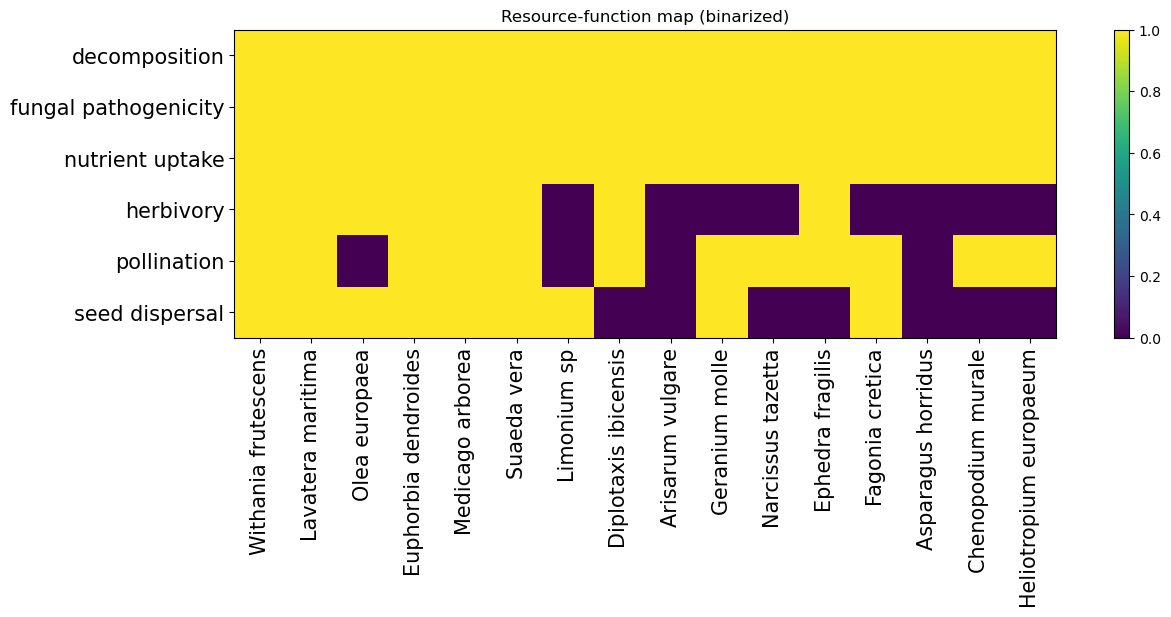

**************************
EXAMPLE OF A SHUFFLED MATRIX
Does the shuffled matrix contains empty rows?
False
Does the shuffled matrix contains empty columns?
False


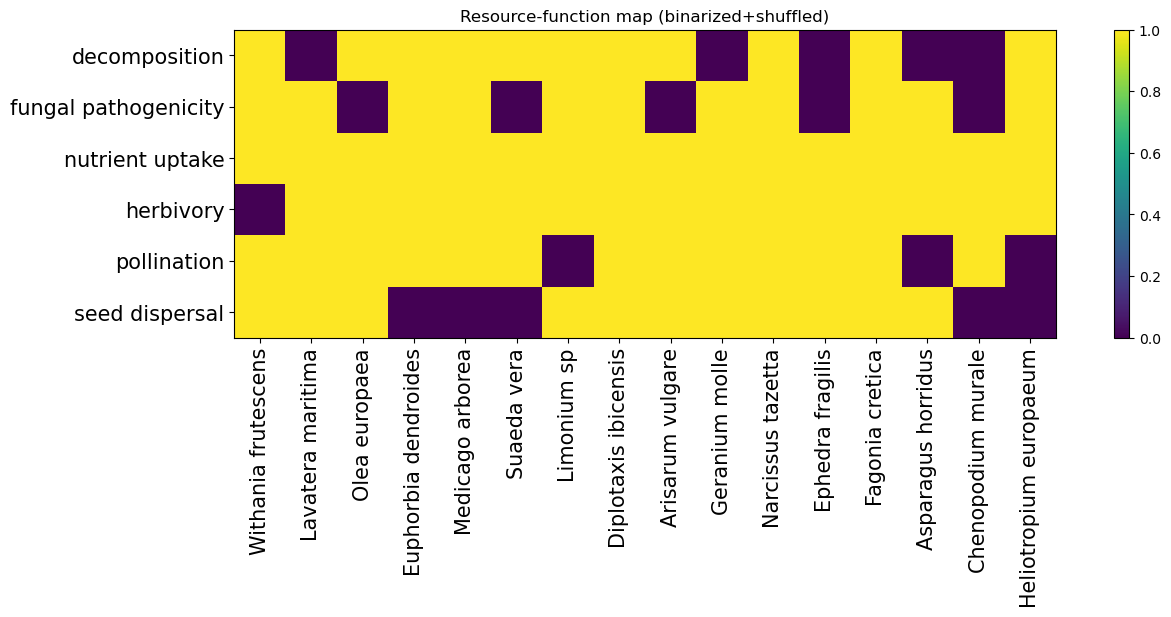

Is this example NOT valid as it reduces the rank? (network not connected)?: False
**********************************************************************************************
RESULTS OF THE ANALYSIS of the null model
binarization threshold: 0.0
NODF of the binarized empirical network 0.7640946502057613
number of randomizations in the null model ensemble 100000
mean value of NODF found in the null model ensemble 0.660264508135486
p-value of the null model= 8e-05
where this p-value is the percentage of shuffled matrices with a NODF larger or equal than the empirical
**********************************************************************************************


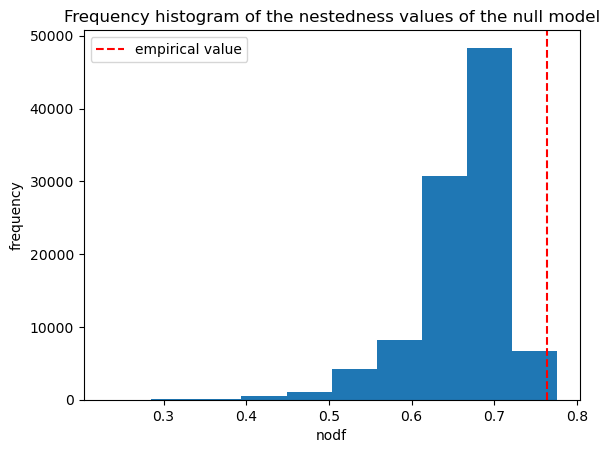

In [4]:
#shuffling the binarized one
def shuffle_matrix(matrix):
    flattened_matrix = matrix.flatten()
    np.random.shuffle(flattened_matrix)
    shuffled_matrix = flattened_matrix.reshape(matrix.shape)
    return shuffled_matrix


#matrix binarization (NODF works for binary matrices...)
threshold, upper, lower = 0., 1, 0
print('Thresholding the resource-function matrix with threshold = ',threshold)

#plot of the binarized matrix
mat=np.where(np.transpose(weights)>threshold, upper, lower)
plot_heatmap(mat, plant_names, function_names,'Resource-function map (binarized)')
plt.show()

#ANALYSIS
#print('Analysis applied to the binary case,only if non-thresholded')
#print('PLANT SPECIES:')
#print('degree of each species in the binarized:',sum(mat))
#print('strength of each species in the non-binarized', sum(np.transpose(weights)))
#print('average weight per link for species (caution, only for threshold zero):',sum(np.transpose(weights))/sum(mat))
#plt.plot(sum(mat),sum(np.transpose(weights)),'o')
#plt.xlabel('degree of plant species node')
#plt.ylabel('strength of plant species node')
#plt.show()
#print('Pearson correlation and p-value:',sp.stats.pearsonr(sum(mat), sum(np.transpose(weights))))
#plt.plot(sum(mat),sum(np.transpose(weights))/sum(mat),'o')
#plt.xlabel('degree of plant species node')
#plt.ylabel('average weight of links per plant species node')
#plt.show()
#print('Pearson correlation and p-value:',sp.stats.pearsonr(sum(mat), sum(np.transpose(weights))/sum(mat)))


#print('')

#print('FUNCTIONS')
#print('degree of each function in the binarized:',sum(np.transpose(mat)))
#print('strength of each function in the non-binarized', sum(weights))
#print('average weight per link for functions (caution, only for threshold zero):',sum(weights)/sum(np.transpose(mat)))
#plt.plot(sum(np.transpose(mat)),sum(weights),'o')
#plt.xlabel('degree of function node')
#plt.ylabel('strength of function node')
#plt.show()
#print('Pearson correlation and p-value:',sp.stats.pearsonr(sum(np.transpose(mat)), sum(weights)))
#plt.plot(sum(np.transpose(mat)),sum(weights)/sum(np.transpose(mat)),'o')
#plt.xlabel('degree of function node')
#plt.ylabel('average weight of links per function node')
#plt.show()
#print('Pearson correlation and p-value:',sp.stats.pearsonr(sum(np.transpose(mat)), sum(weights)/sum(np.transpose(mat))))

print('**************************')
print('EXAMPLE OF A SHUFFLED MATRIX')
#example of a randomized one
mat_shu=shuffle_matrix(mat)
#check if the shuffled one has zeroes
print('Does the shuffled matrix contains empty rows?')
print((mat_shu == 0).all(axis=0).any())
print('Does the shuffled matrix contains empty columns?')
print((mat_shu == 0).all(axis=1).any())
plot_heatmap(mat_shu, plant_names, function_names,'Resource-function map (binarized+shuffled)')
plt.show()
print('Is this example NOT valid as it reduces the rank? (network not connected)?:',(mat_shu == 0).all(axis=0).any() or (mat_shu == 0).all(axis=1).any())

#another example where we shuffle the quantitative matrix
#print('EXAMPLE')
#weights_shu=shuffle_matrix(np.transpose(weights))
#mat_shu=np.where(weights_shu>threshold, upper, lower)
#print('Is this example NOT valid as it reduces the rank? (network not connected)?:',(mat_shu == 0).all(axis=0).any() or (mat_shu == 0).all(axis=1).any())
#plt.plot(sum(mat_shu),sum(weights_shu)/sum(mat_shu),'o',label='shuffled')
#plt.xlabel('degree of function node')
#plt.ylabel('average weight of links per function node')
#plt.legend()
#plt.show()
#print('Pearson correlation and p-value for null:',sp.stats.pearsonr(sum(mat_shu), sum(weights_shu)/sum(mat_shu)))



#nodf score and its null model (quick and dirty) for binary matrices
nodf_score = NestednessCalculator(mat).nodf(mat)
nodf_empirical=nodf_score

#null model
null_nodf=[]
aux=0
num_itera=100000
for i in range(num_itera):
    mat_shu=shuffle_matrix(mat)
    #the shuffled matrix cannot have empty columns or empty rows
    while((mat_shu == 0).all(axis=0).any() or (mat_shu == 0).all(axis=1).any()):
        mat_shu=shuffle_matrix(mat)
    nodf_score = NestednessCalculator(mat_shu).nodf(mat_shu)
    null_nodf.append(nodf_score)
    if(nodf_score>=nodf_empirical):
        aux=aux+1
print('**********************************************************************************************')
print('RESULTS OF THE ANALYSIS of the null model')
print('binarization threshold:',threshold)
print('NODF of the binarized empirical network',nodf_empirical)
print('number of randomizations in the null model ensemble',num_itera)
print('mean value of NODF found in the null model ensemble',np.mean(null_nodf))
print('p-value of the null model=',aux/num_itera)
print('where this p-value is the percentage of shuffled matrices with a NODF larger or equal than the empirical')
print('**********************************************************************************************')
plt.hist(null_nodf)
plt.axvline(x = nodf_empirical, label='empirical value',color = 'red', linestyle = '--')
plt.xlabel('nodf')
plt.ylabel('frequency')
plt.title('Frequency histogram of the nestedness values of the null model')
plt.legend()
plt.show()
    

## NULL MODEL FOR VARYING BINARIZATION THRESHOLDS

threshold, p-value, nodf empirical, mean nodf_null
0.01 0.00022 0.7715020576131687 0.6577603669924775
threshold, p-value, nodf empirical, mean nodf_null
0.03 0.01329 0.742283950617284 0.6504627054324185
threshold, p-value, nodf empirical, mean nodf_null
0.05 0.00013 0.7798765432098765 0.6287676366549063
threshold, p-value, nodf empirical, mean nodf_null
0.07 0.00013 0.7798765432098765 0.6292725833271658
threshold, p-value, nodf empirical, mean nodf_null
0.09 0.00018 0.7774074074074074 0.6185671114671298
threshold, p-value, nodf empirical, mean nodf_null
0.11 0.00128 0.7426807760141093 0.6009273986127067
threshold, p-value, nodf empirical, mean nodf_null
0.13 0.00451 0.7190182245737802 0.5945144824097648
threshold, p-value, nodf empirical, mean nodf_null
0.15 3e-05 0.7606554967666079 0.5671772330365122
threshold, p-value, nodf empirical, mean nodf_null
0.17 0.0014 0.7006172839506174 0.552318836260652
threshold, p-value, nodf empirical, mean nodf_null
0.19 0.00658 0.6471514082625193 0.52

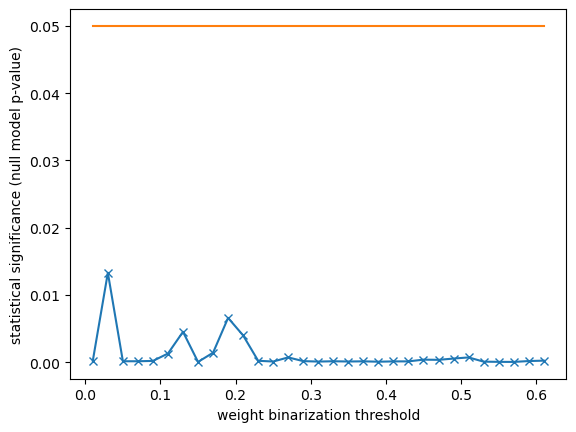

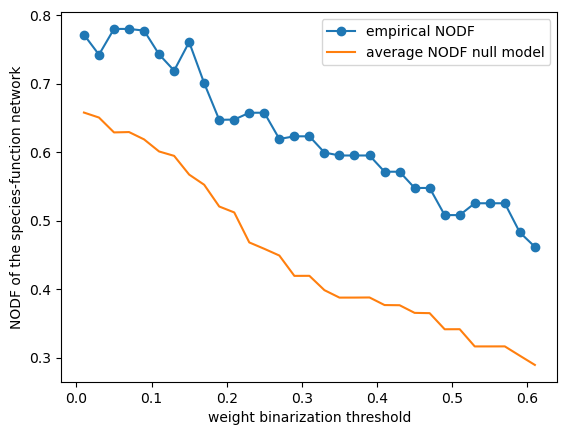

In [5]:
#we do the same but varying the binarization threshold
p_list=[]
threshold_list=[]
nodf_list=[]
nodf_null_list=[]
for j in range(50):
    threshold=0.01*(2*j+1)
    mat=np.where(np.transpose(weights)>threshold, upper, lower)
    if((mat == 0).all(axis=0).any() or (mat == 0).all(axis=1).any()):
        print('the binarization is destroying a whole row or column, stop')
        break
        
    nodf_score = NestednessCalculator(mat).nodf(mat)
    nodf_empirical=nodf_score
    
    #null model
    null_nodf=[]
    aux=0
    num_itera=100000
    aux_nodf=0
    for i in range(num_itera):
        mat_shu=shuffle_matrix(mat)
        #the shuffled matrix cannot have empty columns or empty rows
        while((mat_shu == 0).all(axis=0).any() or (mat_shu == 0).all(axis=1).any()):
            mat_shu=shuffle_matrix(mat)
        nodf_score = NestednessCalculator(mat_shu).nodf(mat_shu)
        null_nodf.append(nodf_score)
        aux_nodf=aux_nodf+nodf_score
        if(nodf_score>=nodf_empirical):
            aux=aux+1
    nodf_null_list.append(aux_nodf/num_itera)
    threshold_list.append(threshold)
    p_list.append(aux/num_itera)
    nodf_list.append(nodf_empirical)
    print('threshold, p-value, nodf empirical, mean nodf_null')
    print(threshold,aux/num_itera,nodf_empirical,aux_nodf/num_itera)
plt.plot(threshold_list, p_list, '-x')
plt.plot(threshold_list, [0.05 for i in threshold_list], '-',label='p-value=0.05')
plt.xlabel('weight binarization threshold')
plt.ylabel('statistical significance (null model p-value)')
plt.show()

plt.plot(threshold_list, nodf_list, '-o',label='empirical NODF')
plt.plot(threshold_list, nodf_null_list, '-',label='average NODF null model')
plt.xlabel('weight binarization threshold')
plt.ylabel('NODF of the species-function network')
plt.legend()
plt.show()

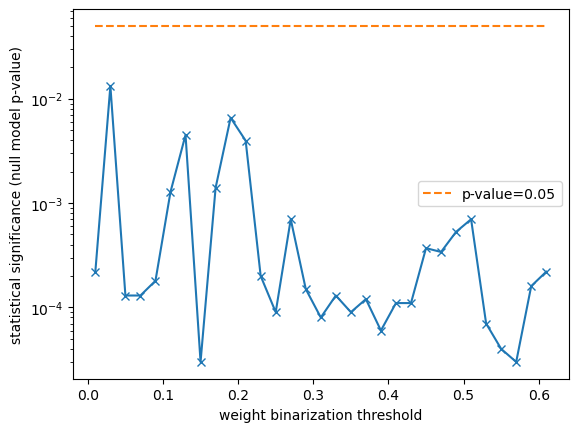

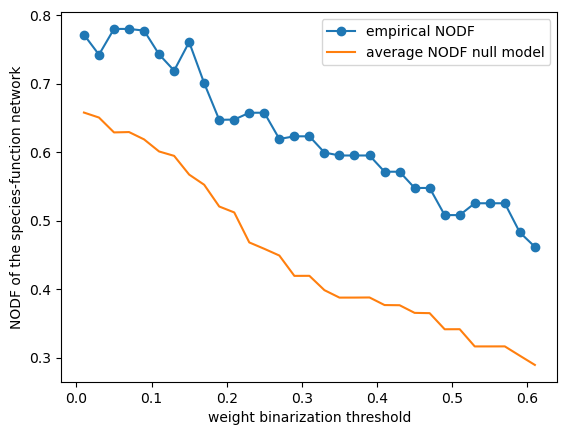

In [6]:
plt.plot(threshold_list, p_list, '-x')
plt.plot(threshold_list, [0.05 for i in threshold_list], '--',label='p-value=0.05')
plt.xlabel('weight binarization threshold')
plt.ylabel('statistical significance (null model p-value)')
plt.yscale('log')
plt.legend()
plt.show()

plt.plot(threshold_list, nodf_list, '-o',label='empirical NODF')
plt.plot(threshold_list, nodf_null_list, '-',label='average NODF null model')
plt.xlabel('weight binarization threshold')
plt.ylabel('NODF of the species-function network')
plt.legend()
plt.show()

# COMPUTATION OF NESTEDNESS-BASED RANKINGS AND THEIR NULL MODEL

the order of appearance is:
['decomposition', 'fungal pathogenicity', 'nutrient uptake', 'herbivory', 'pollination', 'seed dispersal']
[11.43419959  6.00806051  5.64819072  5.63206327  4.15448019  2.06445833]

average null model functions [5.81223281 5.81338132 5.80782865 5.83122001 5.82171943 5.85507038]
1.3090720487273437
1.3329505381740818
1.3121862264732473
1.3381000599134454
1.3287336617609107
1.3374951413508038
['decomposition', 'fungal pathogenicity', 'nutrient uptake', 'herbivory', 'pollination', 'seed dispersal']


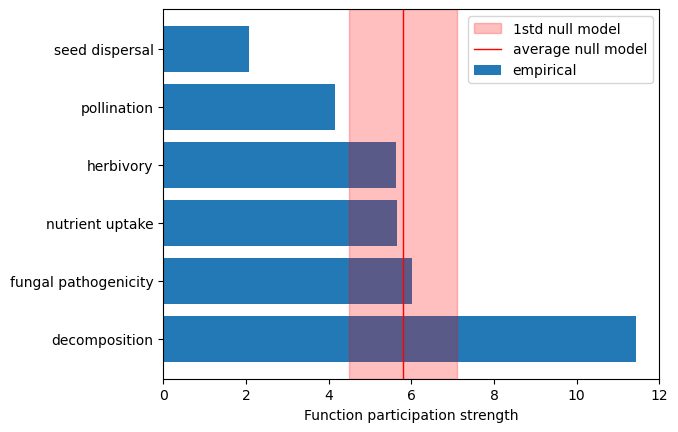

the order of appearance is:
['Withania frutescens', 'Lavatera maritima', 'Olea europaea', 'Euphorbia dendroides', 'Medicago arborea', 'Suaeda vera', 'Limonium sp', 'Diplotaxis ibicensis', 'Arisarum vulgare', 'Geranium molle', 'Narcissus tazetta', 'Ephedra fragilis', 'Fagonia cretica', 'Asparagus horridus', 'Chenopodium murale', 'Heliotropium europaeum']
[4.06004227 3.55394497 3.07213051 3.02835609 2.53799559 2.49802727
 2.30808198 1.9957552  1.93355112 1.82934677 1.60098357 1.53314223
 1.4175139  1.26865225 1.23815491 1.06577397]

average null model plants [2.19179687 2.17443562 2.17434811 2.1954684  2.17725543 2.18302761
 2.1855816  2.18893804 2.1729457  2.20418435 2.18254066 2.17477081
 2.18794152 2.18426091 2.18627732 2.17767964]
0.852429444151313
0.8565128911242329
0.8506907371521164
0.8540824056478976
0.8555885784321514
0.8647934838188404
0.8616956020377405
0.8567452825662614
0.8588247171109423
0.8503824680074701
0.8541656221085968
0.8589928302794266
0.8601415120607561
0.855697367

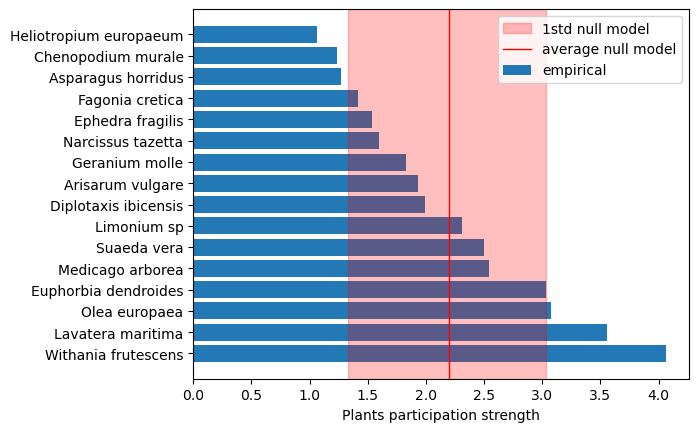

In [7]:
#for functions
print('the order of appearance is:')
print(function_names)
print(sum(weights[:]))
print()
num_iter=10000

lista_ranking_null=np.zeros(6)
lista_ranking_null_1=[]
lista_ranking_null_2=[]
lista_ranking_null_3=[]
lista_ranking_null_4=[]
lista_ranking_null_5=[]
lista_ranking_null_6=[]
for i in range(num_iter):
    weights_shu=shuffle_matrix(weights)
    #the shuffled matrix cannot have empty columns or empty rows
    while((weights_shu == 0).all(axis=0).any() or (weights_shu == 0).all(axis=1).any()):
        weights_shu=shuffle_matrix(weights)
    lista_ranking_null = lista_ranking_null + np.array(sum(weights_shu[:]))
    lista_ranking_null_1.append(sum(weights_shu[:])[0])
    lista_ranking_null_2.append(sum(weights_shu[:])[1])
    lista_ranking_null_3.append(sum(weights_shu[:])[2])
    lista_ranking_null_4.append(sum(weights_shu[:])[3])
    lista_ranking_null_5.append(sum(weights_shu[:])[4])
    lista_ranking_null_6.append(sum(weights_shu[:])[5])

print('average null model functions',lista_ranking_null/num_iter)
print(np.std(lista_ranking_null_1))
print(np.std(lista_ranking_null_2))
print(np.std(lista_ranking_null_3))
print(np.std(lista_ranking_null_4))
print(np.std(lista_ranking_null_5))
print(np.std(lista_ranking_null_6))

# Make a random dataset:
bars = function_names
print(function_names)

# Create bars
plt.barh(function_names,sum(weights[:]),alpha=0.99,label='empirical')
#ymin = position, ymax = position
plt.axvspan(5.8+1.3, 5.8-1.3, alpha=0.25, color='red',label='1std null model')
#plt.axvline(x=5.8+1.3, color='red', linestyle='--', linewidth=1, label='+1std null model')
#plt.axvline(x=5.8-1.3, color='red', linestyle='--', linewidth=1, label='-1std null model')
plt.axvline(x=5.8, color='red', linestyle='-', linewidth=1, label='average null model')
plt.xlabel('Function participation strength')
plt.legend()
# Show graphic
plt.show()


#for species
print('the order of appearance is:')
print(plant_names)
print(sum(np.transpose(weights[:,:])))
print()

num_iter=10000

lista_plant_ranking_null=np.zeros(16)
lista_plant_ranking_null_1=[]
lista_plant_ranking_null_2=[]
lista_plant_ranking_null_3=[]
lista_plant_ranking_null_4=[]
lista_plant_ranking_null_5=[]
lista_plant_ranking_null_6=[]
lista_plant_ranking_null_7=[]
lista_plant_ranking_null_8=[]
lista_plant_ranking_null_9=[]
lista_plant_ranking_null_10=[]
lista_plant_ranking_null_11=[]
lista_plant_ranking_null_12=[]
lista_plant_ranking_null_13=[]
lista_plant_ranking_null_14=[]
lista_plant_ranking_null_15=[]
lista_plant_ranking_null_16=[]
for i in range(num_iter):
    weights_shu=shuffle_matrix(np.transpose(weights))
    #the shuffled matrix cannot have empty columns or empty rows
    while((weights_shu == 0).all(axis=0).any() or (weights_shu == 0).all(axis=1).any()):
        weights_shu=shuffle_matrix(np.transpose(weights))
    lista_plant_ranking_null = lista_plant_ranking_null + np.array(sum(weights_shu[:]))
    lista_plant_ranking_null_1.append(sum(weights_shu[:])[0])
    lista_plant_ranking_null_2.append(sum(weights_shu[:])[1])
    lista_plant_ranking_null_3.append(sum(weights_shu[:])[2])
    lista_plant_ranking_null_4.append(sum(weights_shu[:])[3])
    lista_plant_ranking_null_5.append(sum(weights_shu[:])[4])
    lista_plant_ranking_null_6.append(sum(weights_shu[:])[5])
    lista_plant_ranking_null_7.append(sum(weights_shu[:])[6])
    lista_plant_ranking_null_8.append(sum(weights_shu[:])[7])
    lista_plant_ranking_null_9.append(sum(weights_shu[:])[8])
    lista_plant_ranking_null_10.append(sum(weights_shu[:])[9])
    lista_plant_ranking_null_11.append(sum(weights_shu[:])[10])
    lista_plant_ranking_null_12.append(sum(weights_shu[:])[11])
    lista_plant_ranking_null_13.append(sum(weights_shu[:])[12])
    lista_plant_ranking_null_14.append(sum(weights_shu[:])[13])
    lista_plant_ranking_null_15.append(sum(weights_shu[:])[14])
    lista_plant_ranking_null_16.append(sum(weights_shu[:])[15])

print('average null model plants',lista_plant_ranking_null/num_iter)
print(np.std(lista_plant_ranking_null_1))
print(np.std(lista_plant_ranking_null_2))
print(np.std(lista_plant_ranking_null_3))
print(np.std(lista_plant_ranking_null_4))
print(np.std(lista_plant_ranking_null_5))
print(np.std(lista_plant_ranking_null_6))
print(np.std(lista_plant_ranking_null_7))
print(np.std(lista_plant_ranking_null_8))
print(np.std(lista_plant_ranking_null_9))
print(np.std(lista_plant_ranking_null_10))
print(np.std(lista_plant_ranking_null_11))
print(np.std(lista_plant_ranking_null_12))
print(np.std(lista_plant_ranking_null_13))
print(np.std(lista_plant_ranking_null_14))
print(np.std(lista_plant_ranking_null_15))
print(np.std(lista_plant_ranking_null_16))


# Create bars
#plt.bar(function_names,lista_ranking_null/num_iter,alpha=0.3,label='null model')
plt.barh(plant_names,sum(np.transpose(weights[:,:])),alpha=0.99,label='empirical')
plt.axvspan(2.18+0.85, 2.18-0.85, alpha=0.25, color='red',label='1std null model')
#plt.axvline(x=2.2+0.85, color='red', linestyle='--', linewidth=1, label='+1std null model')
#plt.axvline(x=2.2-0.85, color='red', linestyle='--', linewidth=1, label='-1std null model')
plt.axvline(x=2.2, color='red', linestyle='-', linewidth=1, label='average null model')
plt.xlabel('Plants participation strength')
plt.legend()
# Show graphic
plt.show()


## $\Phi, \Pi$ NETWORKS

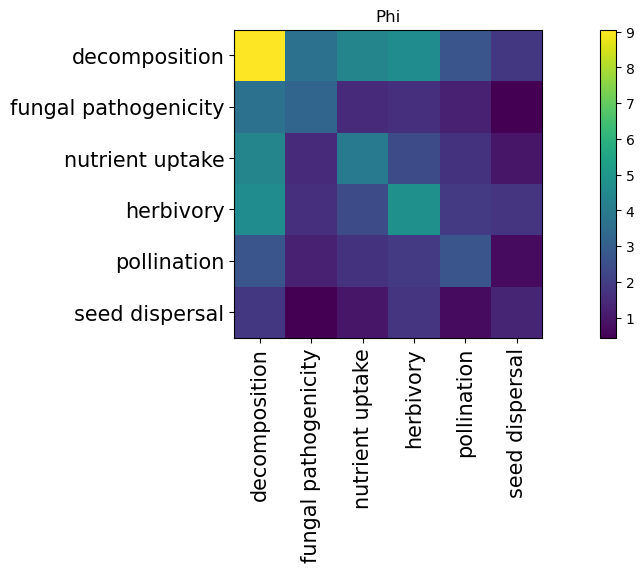

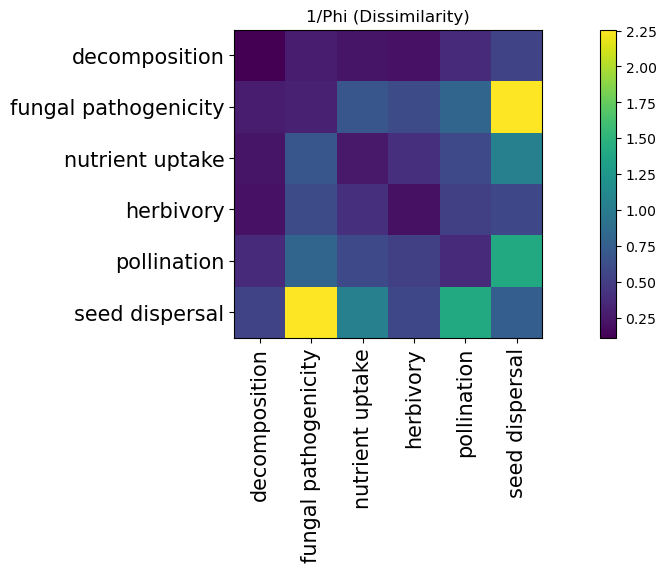

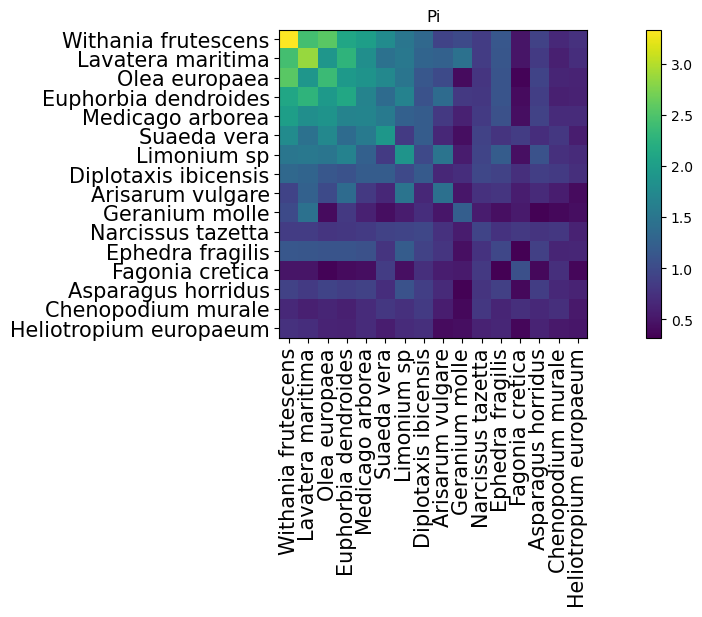

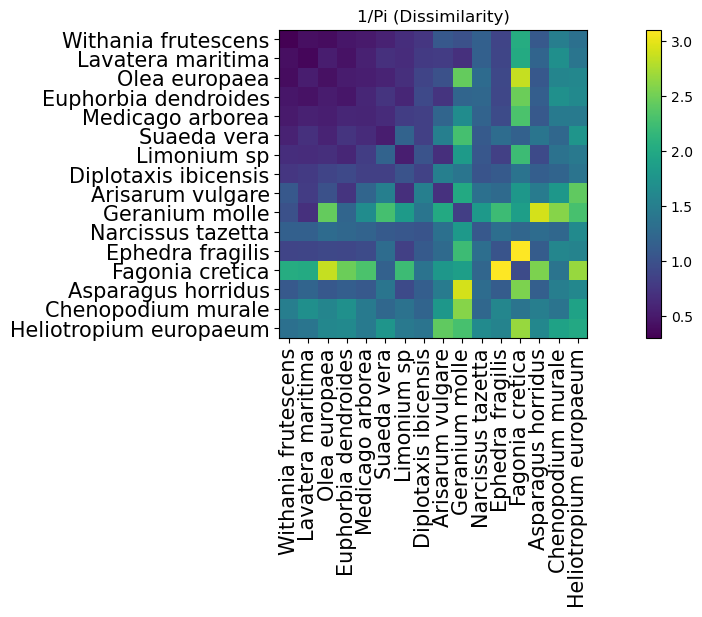

In [8]:
Phi = np.matmul(np.transpose(weights),weights)
dissim_Phi = 1/Phi

# Plot the heatmap
plot_heatmap(Phi, function_names, function_names,'Phi')
plot_heatmap(dissim_Phi, function_names, function_names,'1/Phi (Dissimilarity)')
plt.show()


Pi = np.matmul(weights,np.transpose(weights))
dissim_Pi = 1/Pi

# Plot the heatmap
plot_heatmap(Pi, plant_names, plant_names,'Pi')
plot_heatmap(dissim_Pi, plant_names, plant_names,'1/Pi (Dissimilarity)')
plt.show()






## HIERARCHICAL CLUSTERING from $\Phi, \Pi$


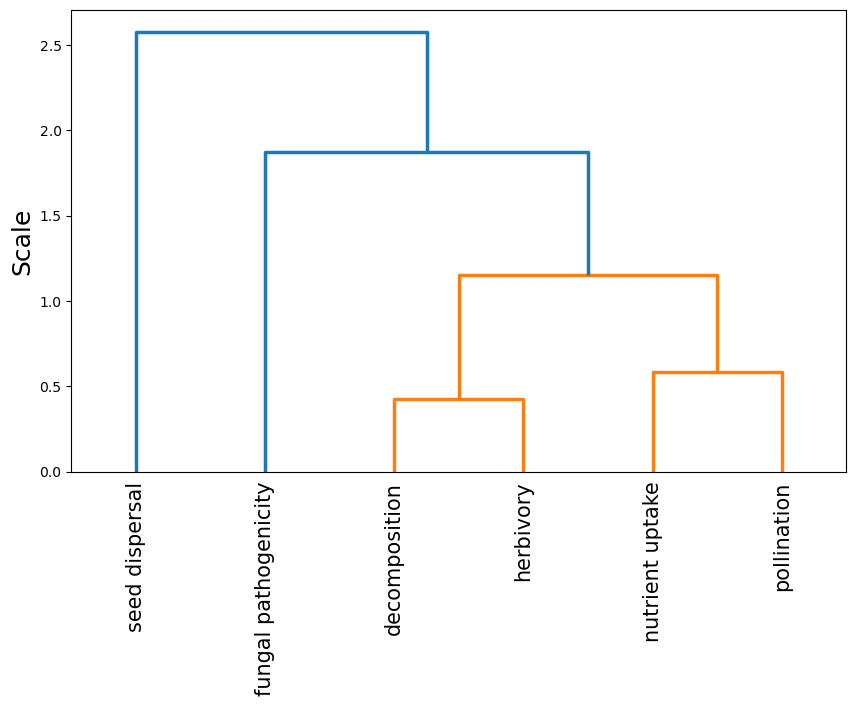

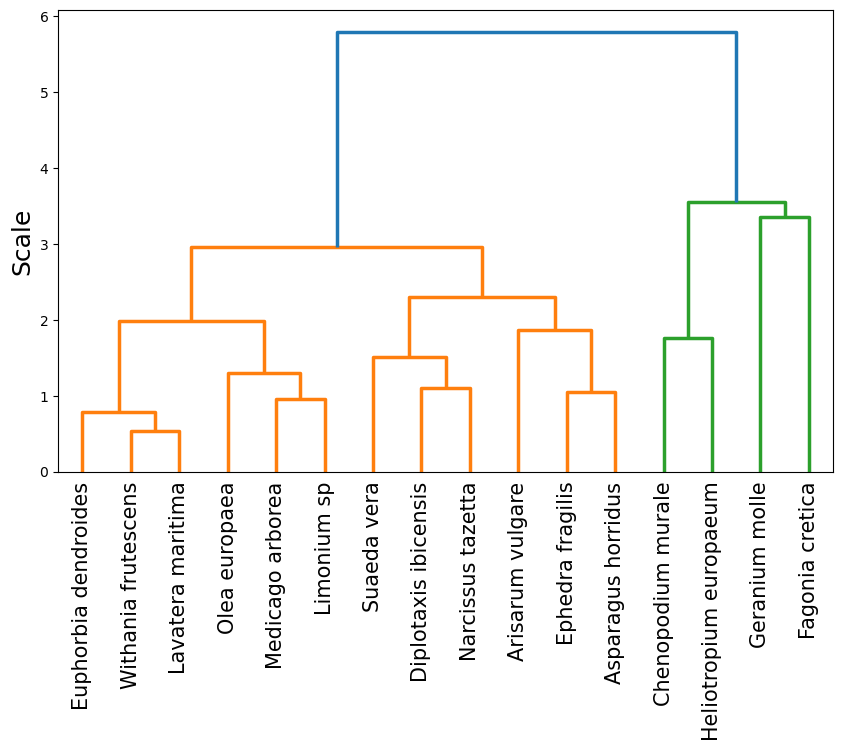

In [9]:
# Define the leaf names
leaf_names = function_names

# Plot the dendrogram with annotated leaf names
plot_dendrogram_with_names(dissim_Phi, leaf_names)

# Define the leaf names
leaf_names = plant_names

# Plot the dendrogram with annotated leaf names
plot_dendrogram_with_names(dissim_Pi, leaf_names)

# Plant and Function Keystone scores along with their null model


PLANT SPECIES:


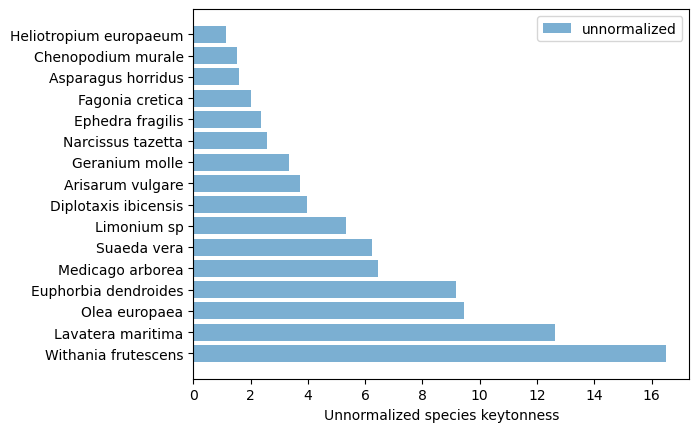

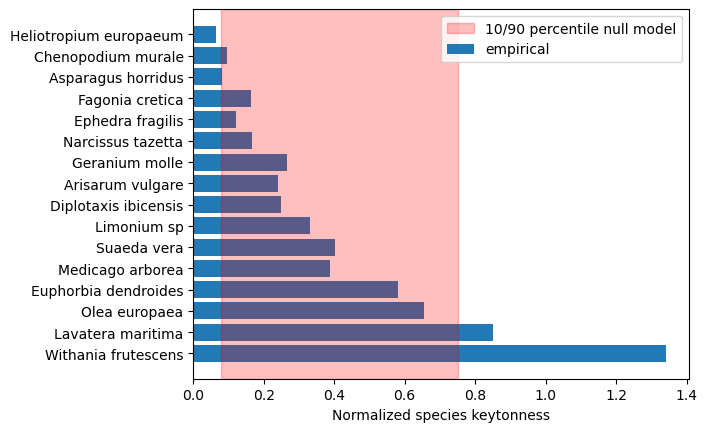


*******************************************

FUNCTIONS:


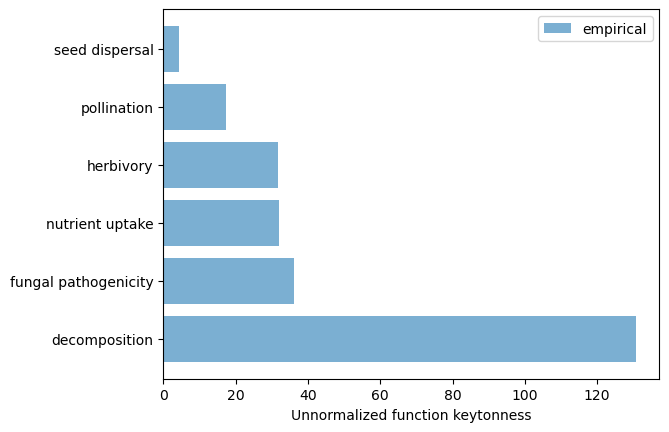

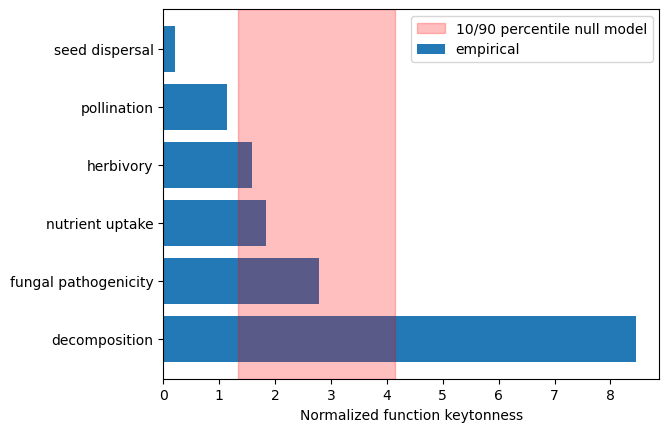

In [10]:
#PLANT SPECIES
print('PLANT SPECIES:')

# Define the shape of the 3D array
shape = (16, 6, 6)  # Example shape with three indices

# Initialize a 3D array with zeros
conditioned_phi = np.zeros(shape, dtype=float)
for i in range(16):
    for j in range(6):
        for k in range(6):
            conditioned_phi[i,j,k]=weights[i,j]*weights[i,k]
                    
#UNNORMALIZED VERSION OF THE RANKING
unnormalized_keystoness_species = [np.sum(conditioned_phi[i]) for i in range(16)]
# Create bars
plt.barh(plant_names,unnormalized_keystoness_species,alpha=0.59,label='unnormalized')
plt.xlabel('Unnormalized species keytonness')
plt.legend()
# Show graphic
plt.show()

#NORMALIZED VERSION OF THE RANKING
keystonness_species=np.zeros([16])
for i in range(16):
    for alpha in range(6):
        NUMERATOR=sum(conditioned_phi[i,:,:])[alpha]
        AAA=sum([sum(conditioned_phi[j,:,:])[alpha] for j in range(16)]) #normalization is key
        keystonness_species[i]=keystonness_species[i]+NUMERATOR/AAA

# Create bars
plt.barh(plant_names,keystonness_species,alpha=0.99,label='empirical')
#plt.axvspan(0.37+0.27, 0.37-0.27, alpha=0.25, color='red',label='1std null model')
plt.axvspan(0.08, 0.75, alpha=0.25, color='red',label='10/90 percentile null model')
plt.xlabel('Normalized species keytonness')
plt.legend()
# Show graphic
plt.show()


print('')
print('*******************************************')
print('')
print('FUNCTIONS:')

# Define the shape of the 3D array
shape = (6, 16, 16)  # Example shape with three indices

# Initialize a 3D array with zeros
conditioned_pi = np.zeros(shape, dtype=float)
for i in range(6):
    for j in range(16):
        for k in range(16):
            conditioned_pi[i,j,k]=weights[j,i]*weights[k,i]
            

#UNNORMALIZED VERSION OF THE RANKING
unnormalized_keystoness_function = [np.sum(conditioned_pi[i]) for i in range(6)]
# Create bars
plt.barh(function_names,unnormalized_keystoness_function,alpha=0.59,label='empirical')
plt.xlabel('Unnormalized function keytonness')
plt.legend()
# Show graphic
plt.show()

#NORMALIZED VERSION OF THE RANKING
keystonness_function=np.zeros([6])
for i in range(6):
    for alpha in range(16):
        NUMERATOR=sum(conditioned_pi[i,:,:])[alpha]
        AAA=sum([sum(conditioned_pi[j,:,:])[alpha] for j in range(6)]) #normalization is key
        keystonness_function[i]=keystonness_function[i]+NUMERATOR/AAA

# Create bars
plt.barh(function_names,keystonness_function,alpha=0.99,label='empirical')
#plt.axvspan(2.66+1.1, 2.66-1.1, alpha=0.25, color='red',label='1std null model')
plt.axvspan(1.33, 4.14, alpha=0.25, color='red',label='10/90 percentile null model')
plt.xlabel('Normalized function keytonness')
plt.legend()
# Show graphic
plt.show()

    

# Keystonness null models

In [11]:
#PLANTS
num_iter=10000
keystonness_species=np.zeros([16,num_iter])
for realization in range(num_iter):
    weights_shu=shuffle_matrix(weights)
    #the shuffled matrix cannot have empty columns or empty rows
    while((weights_shu == 0).all(axis=0).any() or (weights_shu == 0).all(axis=1).any()):
        weights_shu=shuffle_matrix(weights)

    # Define the shape of the 3D array
    shape = (16, 6, 6)  # Example shape with three indices

    # Initialize a 3D array with zeros
    conditioned_phi = np.zeros(shape, dtype=float)
    for i in range(16):
        for j in range(6):
            for k in range(6):
                conditioned_phi[i,j,k]=weights_shu[i,j]*weights_shu[i,k]
                    

    #NORMALIZED VERSION OF THE RANKING
    for i in range(16):
        for alpha in range(6):
            NUMERATOR=sum(conditioned_phi[i,:,:])[alpha]
            AAA=sum([sum(conditioned_phi[j,:,:])[alpha] for j in range(16)]) #normalization is key
            keystonness_species[i,realization]=keystonness_species[i,realization]+NUMERATOR/AAA
    

ave_keystonness=np.zeros(16)
std_keystonness=np.zeros(16)
perc5_keystonness=np.zeros(16)
perc95_keystonness=np.zeros(16)
for i in range(16):
    ave_keystonness[i]=np.mean(keystonness_species[i,:])
    std_keystonness[i]=np.std(keystonness_species[i,:])
    perc95_keystonness[i]=np.percentile(keystonness_species[i,:],90)
    perc5_keystonness[i]=np.percentile(keystonness_species[i,:],10)

print('medio null model:',ave_keystonness)
print('std null model:',std_keystonness)
print('perc 5 null model:',perc5_keystonness)
print('perc 95 null model:',perc95_keystonness)
    

medio null model: [0.37709706 0.37344709 0.37924644 0.37487394 0.378762   0.37485261
 0.37614012 0.36980036 0.36965184 0.37826765 0.37522798 0.37724911
 0.37457913 0.37359917 0.37581108 0.37139442]
std null model: [0.27337973 0.27185714 0.27173489 0.26783788 0.26815854 0.26871771
 0.27451965 0.26451859 0.26938478 0.27317978 0.27183083 0.27358799
 0.26740931 0.2662336  0.27123758 0.26664923]
perc 5 null model: [0.08376055 0.08035278 0.08626193 0.08101182 0.08496456 0.08368665
 0.08439936 0.08213774 0.07674244 0.08110026 0.08430916 0.08136132
 0.08153382 0.08285807 0.07940285 0.08107388]
perc 95 null model: [0.75278374 0.73876635 0.75417359 0.74640354 0.74711874 0.75101657
 0.75679264 0.7374348  0.74233933 0.75195199 0.74617795 0.75594891
 0.73885122 0.73902266 0.74854628 0.73903149]


In [12]:
#FUNCTIONS
num_iter=10000
keystonness_function=np.zeros([6,num_iter])
for realization in range(num_iter):
    weights_shu=shuffle_matrix(weights)
    #the shuffled matrix cannot have empty columns or empty rows
    while((weights_shu == 0).all(axis=0).any() or (weights_shu == 0).all(axis=1).any()):
        weights_shu=shuffle_matrix(weights)

    # Define the shape of the 3D array
    shape = (6, 16, 16)  # Example shape with three indices

    # Initialize a 3D array with zeros
    conditioned_pi = np.zeros(shape, dtype=float)
    for i in range(6):
        for j in range(16):
            for k in range(16):
                conditioned_pi[i,j,k]=weights_shu[j,i]*weights_shu[k,i]
                    

    #NORMALIZED VERSION OF THE RANKING
    for i in range(6):
        for alpha in range(16):
            NUMERATOR=sum(conditioned_pi[i,:,:])[alpha]
            AAA=sum([sum(conditioned_pi[j,:,:])[alpha] for j in range(6)]) #normalization is key
            keystonness_function[i,realization]=keystonness_function[i,realization]+NUMERATOR/AAA
            

ave_keystonness=np.zeros(6)
std_keystonness=np.zeros(6)
perc5_keystonness=np.zeros(6)
perc95_keystonness=np.zeros(6)
for i in range(6):
    ave_keystonness[i]=np.mean(keystonness_function[i,:])
    std_keystonness[i]=np.std(keystonness_function[i,:])
    perc95_keystonness[i]=np.percentile(keystonness_function[i,:],90)
    perc5_keystonness[i]=np.percentile(keystonness_function[i,:],10)

print('average null model',ave_keystonness)
print('standard deviation null model',std_keystonness)
print('perc 5 null model:',perc5_keystonness)
print('perc 95 null model:',perc95_keystonness)

average null model [2.65219158 2.6538867  2.6673308  2.68503164 2.66905948 2.67249979]
standard deviation null model [1.09986878 1.11079544 1.11685547 1.11805025 1.11529245 1.11658075]
perc 5 null model: [1.31800458 1.29981612 1.32435185 1.31764037 1.30313153 1.3213717 ]
perc 95 null model: [4.15045454 4.13391251 4.17740096 4.18850597 4.18769154 4.16612552]


### END
---